## Random search compression on LeNet-5

In [1]:
import sys
sys.path.append('../')

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import os
import math

from data.mnist import MnistDataset
from models.lenet.lenet import LeNet5
from utils.rnd import RandomController, Individual
from utils.train import *
from utils.weight_sharing import *
from utils.plot import *
from utils.fitness_controller import FitnessController

Setting parameters 

In [3]:
# net train settings
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = 'cpu'
EPOCHS = 100

# net save settings
NET_PATH = '../models/lenet/saves/lenet_relu.save'
NET_TYPE = 'relu'

# random search iter count
NUM_INDIVIDUALS = 400

# random search search settings
REPR_RANGES = [range(1, 51) for _ in range(5)]

# random search save settings
SAVE_RND_FILE = '../results/test_RND_save.csv'
SAVE_EVERY = 1

# range optimization settings
RANGE_OPTIMIZATION = True
RANGE_OPTIMIZATION_TRESHOLD = 0.97
RANGE_OPTIMIZATION_FILE = '../results/lenet-relu-layer-perf.csv'

# target position
TARGET = [1.0, 12.0]
LOCK_TARGET = False

# WS settings
SHARE_ORDER = [0, 1, 2, 3, 4]
RETRAIN_AMOUNT = None #[0, 0, 0, 0, 0]
PREC_REDUCT = None #['f4', 'f4', 'f4', 'f4', 'f4']
CLUST_MOD_FOCUS = None #[0, 0, 0, 0, 0]
CLUST_MOD_SPREAD = None #[0, 0, 0, 0, 0]

Geting somewhat trained LeNet-5

In [4]:
dataset = MnistDataset(BATCH_SIZE, '../data', val_split=0.5)
model = LeNet5(N_CLASSES, NET_TYPE)
model.to(DEVICE)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings, DEVICE)

before_loss = get_accuracy(model, dataset.test_dl, DEVICE)

Setting weight share controller

In [5]:
lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller = WeightShare(model, lam_opt, lam_train, lam_test)
ws_controller.set_reset()

ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


Defining fitness function

In [6]:
def fitness_vals_fc(individual:Individual):
    # reset the net
    ws_controller.reset()
    
    # share weigts by particle
    if individual.data is None:
        individual.data = ws_controller.share(individual.representation, SHARE_ORDER, RETRAIN_AMOUNT, PREC_REDUCT, CLUST_MOD_FOCUS, CLUST_MOD_SPREAD)
    
    return [individual.data['accuracy'], individual.data['compression']]

def fit_from_vals(data, targ_vals):

    # compute fitness
    if data['accuracy'] <= 0.95:
        return data['accuracy']

    return 1 / math.sqrt(pow(1 - ((data['accuracy'] - 0.9) * (1/0.1)), 2) + pow(1 - (data['compression']/targ_vals[1]), 2))

In [7]:
data = {
    'representation': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'share_t': [],
    'train_t': [],
    'acc_t': []
}

data_types = {
    'accuracy': 'float32',
    'accuracy_loss': 'float32',
    'compression': 'float32',
    'share_t': 'float32',
    'train_t': 'float32',
    'acc_t': 'float32'
}

rnd_data = pd.read_csv(SAVE_RND_FILE).astype(data_types) if os.path.exists(SAVE_RND_FILE) else pd.DataFrame(data).astype(data_types)

def logger_fc(rnd_controler:RandomController):
    global rnd_data

    new_data = copy.deepcopy(data)

    indiv = rnd_controler.current_indiv

    new_data['representation'].append(indiv.representation)
    new_data['accuracy'].append(indiv.data['accuracy'])
    new_data['accuracy_loss'].append(before_loss - indiv.data['accuracy'])
    new_data['compression'].append(indiv.data['compression'])
    new_data['share_t'].append(indiv.data['times']['share'])
    new_data['train_t'].append(indiv.data['times']['train'])
    new_data['acc_t'].append(indiv.data['times']['test'])

    # saving progress
    rnd_data = rnd_data.append(pd.DataFrame(new_data).astype(data_types))
    rnd_data.reset_index(drop=True, inplace=True)
    os.makedirs(os.path.dirname(SAVE_RND_FILE), exist_ok=True)
    rnd_data.to_csv(SAVE_RND_FILE, index=False)

Setting ranges with optimization

In [8]:
lam_test_inp = lambda _ : get_accuracy(model, dataset.test_dl, DEVICE)

if RANGE_OPTIMIZATION:
    REPR_RANGES = ws_controller.get_optimized_layer_ranges(REPR_RANGES, lam_test_inp, RANGE_OPTIMIZATION_TRESHOLD, 
        savefile=RANGE_OPTIMIZATION_FILE)

for repr_range in REPR_RANGES:
    print(len(repr_range))

49
47
47
48
47


Running the search

In [9]:
fit_controll = FitnessController(TARGET, fitness_vals_fc, fit_from_vals, target_max_offset=1, lock=LOCK_TARGET)
random = RandomController(REPR_RANGES, fit_controll)

if rnd_data.size != 0:
    random.load_from_pd(rnd_data, True)

random.run(NUM_INDIVIDUALS, logger_fc, verbose = True)

Fitness target update to [1.         7.76750422]
Individual 1/10 (10) evaluated Individual ([7, 19, 39, 28, 35]) fit:3.333818373542426
Individual 2/10 (11) evaluated Individual ([20, 36, 38, 16, 49]) fit:2.6103782019245863
Individual 3/10 (12) evaluated Individual ([28, 33, 18, 48, 22]) fit:2.539515708743419
Individual 4/10 (13) evaluated Individual ([3, 38, 37, 44, 35]) fit:3.8334408726664893
Individual 5/10 (14) evaluated Individual ([42, 22, 41, 12, 48]) fit:2.6106890034074604
Individual 6/10 (15) evaluated Individual ([23, 31, 49, 6, 7]) fit:4.981455180624146
Individual 7/10 (16) evaluated Individual ([23, 26, 6, 6, 29]) fit:4.9470237080211135
Individual 8/10 (17) evaluated Individual ([32, 27, 43, 21, 14]) fit:2.9493350148888284
Individual 9/10 (18) evaluated Individual ([21, 20, 31, 33, 50]) fit:2.5306622897100106
Individual 10/10 (19) evaluated Individual ([44, 18, 29, 40, 15]) fit:2.8472047925671897


[20, 11, 43, 13, 7]

See output

In [10]:
rnd_data

,representation,accuracy,accuracy_loss,compression,share_t,train_t,acc_t,fitness
0,"[23, 33, 43, 23, 12]",0.9852,-0.0006,5.317961,3.252446,0.0,3.855987,2.0
1,"[45, 7, 50, 13, 33]",0.9846,0.0000,5.926410,3.335265,0.0,3.683328,3.0
2,"[7, 32, 12, 26, 17]",0.9844,0.0002,6.512052,1.746838,0.0,3.502718,4.0
3,"[30, 22, 45, 13, 37]",0.9856,-0.0010,5.190836,3.458077,0.0,3.859667,2.0
4,"[7, 15, 28, 16, 34]",0.9854,-0.0008,6.597072,2.541836,0.0,3.595945,4.0
5,"[22, 41, 8, 17, 10]",0.9836,0.0010,6.414914,1.380302,0.0,3.603256,4.0
6,"[20, 11, 43, 13, 7]",0.9850,-0.0004,6.767504,3.428324,0.0,4.597684,5.0
7,"[22, 48, 19, 23, 11]",0.9844,0.0002,5.526874,2.131185,0.0,3.487895,3.0
8,"[42, 22, 16, 28, 46]",0.9858,-0.0012,5.224723,2.038266,0.0,3.931313,2.0
9,"[19, 24, 24, 43, 40]",0.9836,0.0010,4.985909,2.756145,0.0,3.600942,2.0


Plotting data

Text(0.5, 1.0, 'Random search on LeNet-5')

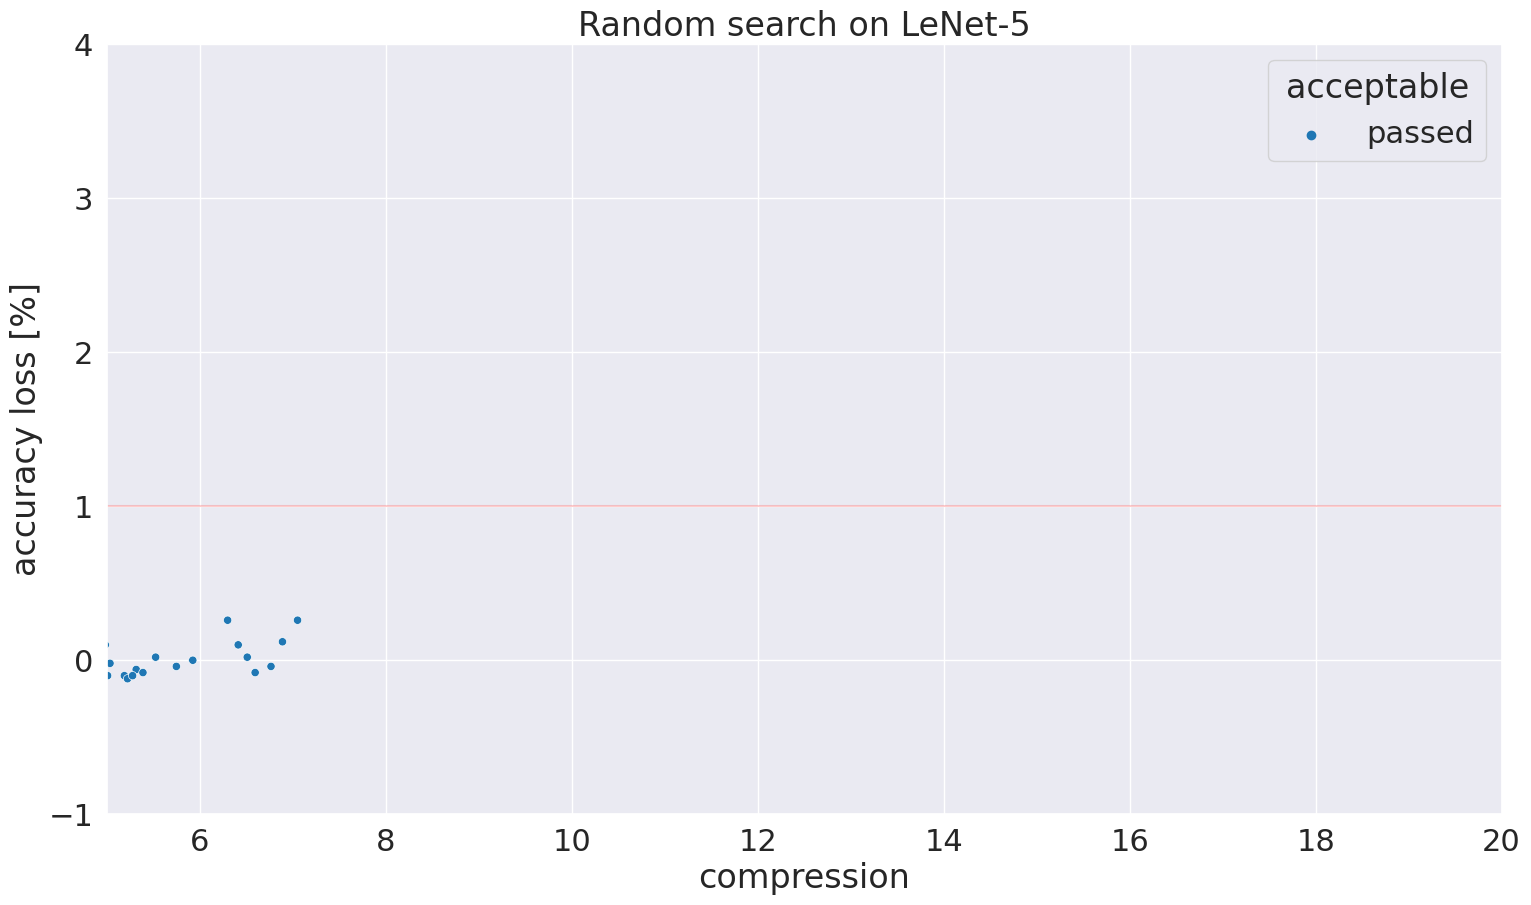

In [11]:
plot_alcr(rnd_data)
plt.title('Random search on LeNet-5')

In [12]:
fit_controll.targ

array([1.        , 7.76750422])